In [1]:
import random
import torch
import drawPlot as dP

## Build dataset

In [2]:
def synthetic_data(w, b, num_examples): 
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.8033, 0.7413]) 
label: tensor([3.2849])


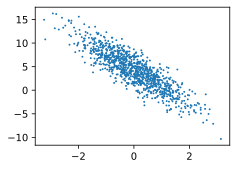

In [5]:
dP.set_figsize()
dP.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## Load dataset

In [6]:
def data_iter(batch_size, features, labels):
    '''读取小批量'''
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # 随机打乱，以随机顺序读取每个样本
    for i in range(0, num_examples, batch_size): # 每次跳batch_size个大小
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices] # yield相当于迭代器

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # X是10*2的tensor，y是10*1的向量
    break

tensor([[-0.9506, -0.3940],
        [-0.9814, -0.3958],
        [-0.3912,  0.6089],
        [-0.9292,  0.2055],
        [ 1.5304,  0.4377],
        [ 0.9673, -0.7974],
        [-1.9641, -1.4486],
        [ 0.6646, -1.1254],
        [ 1.4377, -0.5440],
        [-0.7973,  1.3672]]) 
 tensor([[ 3.6364],
        [ 3.5886],
        [ 1.3598],
        [ 1.6353],
        [ 5.7772],
        [ 8.8445],
        [ 5.2077],
        [ 9.3605],
        [ 8.9320],
        [-2.0374]])


## Initialize parameters

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 均值为0，方差为0.01的正态分布，size和label一样，可以求导
b = torch.zeros(1, requires_grad=True) # 初始都设为0

## Define model

In [9]:
def linreg(X, w, b): 
    """线性回归模型"""
    return torch.matmul(X, w) + b # 矩阵 * 向量 + 偏差

## Set loss function

In [10]:
def squared_loss(y_hat, y): 
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Set optimaizing algorithm

In [11]:
def sgd(params, lr, batch_size): # params这里指 W, b
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  
            param.grad.zero_() # 手动把梯度设为0

# Train

In [15]:
lr = 0.03
num_epochs = 100 #把所有数据扫100遍
net = linreg
loss = squared_loss

In [16]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的⼩批量损失 把X, w, b放进net里做预测，把预测的y和真实的y来做损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 损失求和，算梯度
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度sgd更新参数
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 把整个数据的features放进去，与真实的label做损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 12.823799
epoch 2, loss 12.129522
epoch 3, loss 11.377607
epoch 4, loss 10.869138
epoch 5, loss 10.393953
epoch 6, loss 9.821012
epoch 7, loss 9.144741
epoch 8, loss 8.709083
epoch 9, loss 8.456076
epoch 10, loss 7.993187
epoch 11, loss 7.545763
epoch 12, loss 6.925070
epoch 13, loss 6.679709
epoch 14, loss 6.444710
epoch 15, loss 5.944541
epoch 16, loss 5.787115
epoch 17, loss 5.364336
epoch 18, loss 4.773658
epoch 19, loss 4.499478
epoch 20, loss 4.262448
epoch 21, loss 4.106624
epoch 22, loss 3.855550
epoch 23, loss 3.612691
epoch 24, loss 3.335950
epoch 25, loss 3.202194
epoch 26, loss 2.990379
epoch 27, loss 2.844532
epoch 28, loss 2.669096
epoch 29, loss 2.533565
epoch 30, loss 2.369387
epoch 31, loss 2.224646
epoch 32, loss 2.089353
epoch 33, loss 2.045750
epoch 34, loss 1.958048
epoch 35, loss 1.745644
epoch 36, loss 1.662002
epoch 37, loss 1.603336
epoch 38, loss 1.472674
epoch 39, loss 1.355933
epoch 40, loss 1.279658
epoch 41, loss 1.214625
epoch 42, loss 1.119

In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0523, -0.1305], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.1582], grad_fn=<RsubBackward1>)
